In [1]:
import pandas as pd
import json as json
from pandas import json_normalize
import os
import numpy as np
import csv
from matplotlib import pyplot as plt

import keras
import tensorflow as tf
from keras.layers import Input, Flatten, Dense, Lambda, Reshape, Dropout
from keras.layers import BatchNormalization
from keras.models import Model
from keras.losses import binary_crossentropy
from keras.metrics import mse, accuracy
from keras.callbacks import ReduceLROnPlateau
from scipy.ndimage.filters import uniform_filter1d
from keras import backend as K

keras.backend.clear_session()


srcDir = "../data/preprocessed/"
model_path = srcDir + "models/model_1000split_balanced/"

# Delta Learning

In [2]:
# Load cleaned data

with open(srcDir + "training_data.csv", 'r') as f:
    data = list(csv.reader(f))

df = pd.DataFrame(data[1:], columns=data[0])
df.head()

,height_delta,temperatur_in_grad,niederschlag_in_mm,ist_industriegebiet,ist_wohngebiet,ist_feiertag,sekunde,minute,stunde,wochentag,...,DEVEUI_70B3D50070001779,DEVEUI_70B3D5007000177C,DEVEUI_70B3D50070001780,DEVEUI_70B3D50070001781,DEVEUI_70B3D50070001782,DEVEUI_70B3D50070001786,DEVEUI_70B3D50070001787,DEVEUI_70B3D50070001788,DEVEUI_70B3D50070001789,container_Id
0,0.0,0.33333334,0.0,0.0,1.0,0.0,0.2542373,0.84745765,0.0,0.8333333,...,0,0,0,0,0,0,0,0,1,77
1,0.0,0.28787878,0.0,0.0,1.0,0.0,0.2542373,0.84745765,0.04347826,0.8333333,...,0,0,0,0,0,0,0,0,1,77
2,0.0,0.28787878,0.0,0.0,1.0,0.0,0.2542373,0.84745765,0.08695652,0.8333333,...,0,0,0,0,0,0,0,0,1,77
3,0.0,0.28787878,0.0,0.0,1.0,0.0,0.2542373,0.84745765,0.13043478,0.8333333,...,0,0,0,0,0,0,0,0,1,77
4,0.0,0.28787878,0.0,0.0,1.0,0.0,0.2542373,0.84745765,0.17391305,0.8333333,...,0,0,0,0,0,0,0,0,1,77


In [3]:
# testing data

with open(srcDir + "smoothed_data.csv", 'r') as f:
    smoothed = list(csv.reader(f))

df_smoothed = pd.DataFrame(smoothed[1:], columns=smoothed[0])
df_smoothed.head()

,container_id,height_in_cm,temperatur_in_grad,niederschlag_in_mm,ist_industriegebiet,ist_wohngebiet,ist_feiertag,datum,sekunde,minute,...,DEVEUI_70B3D50070001780,DEVEUI_70B3D50070001781,DEVEUI_70B3D50070001782,DEVEUI_70B3D50070001786,DEVEUI_70B3D50070001787,DEVEUI_70B3D50070001788,DEVEUI_70B3D50070001789,real_height,smoothed_heigth,smoothed_delta
0,77,86,22,0,0,1,0,2020-05-09 00:50:15.726339,15,50,...,0,0,0,0,0,0,1,54.0,43.2,0.0
1,77,86,19,0,0,1,0,2020-05-09 01:50:15.558981,15,50,...,0,0,0,0,0,0,1,54.0,43.2,0.0
2,77,104,19,0,0,1,0,2020-05-09 02:50:15.408009,15,50,...,0,0,0,0,0,0,1,36.0,43.2,0.0
3,77,104,19,0,0,1,0,2020-05-09 03:50:15.256986,15,50,...,0,0,0,0,0,0,1,36.0,43.2,0.0
4,77,104,19,0,0,1,0,2020-05-09 04:50:15.056761,15,50,...,0,0,0,0,0,0,1,36.0,41.4,2.7999992


In [4]:
df = df.loc[df["container_Id"] == "1"]

In [5]:
# exclude column "container_Id" at the end of dataframe
data = np.array(df.values.tolist())
data = data[:,:len(df.keys())-1]

In [6]:
delta_model = keras.models.load_model(model_path + "model")

In [7]:
data_in = np.array(data[:, 1:]).astype("float32")
data_truth = np.array(data[:, 0]).astype("float32")
print(data_in.shape)
print(data_truth.shape)

(7306, 97)
(7306,)


In [8]:
# 254 is max height
# 46 is max delta hight

multiplier = 46

def prediction(index, x_set, y_set):
    data_point = np.array([x_set[index]])
    pred_height = delta_model.predict(data_point)[0][0] * multiplier
    real_height = y_set[index] * multiplier
    
    print("Real value: ", real_height, " estimated: ", pred_height)
    
def prediction_Plot(x_set, y_set, num):
    index_list = np.linspace(0, len(x_set)-1, num).astype("int")
    #print(index_list)
    pred_list = []
    sum_heigth = 0.0
    for x in index_list:
        data_point = np.array([x_set[x]])
        pred_height = delta_model.predict(data_point)[0][0] * multiplier
        real_height = y_set[x] * multiplier
        pred_list.append(abs(pred_height - real_height))
        sum_heigth = sum_heigth + abs(pred_height - real_height)
        
    print("Average absolute error in ", num, " data points: " , sum_heigth / num)
    plt.plot(pred_list)
    plt.ylabel('total Error')
    plt.savefig(model_path + "plots/Prediction_plot.svg")
    plt.show()

In [9]:
prediction(10, data_in, data_truth)

Real value:  1.3333282172679901  estimated:  -0.6138131655752659


Average absolute error in  100  data points:  1.201721085133031


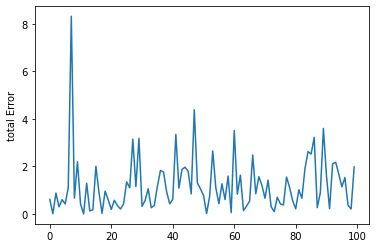

In [10]:
prediction_Plot(data_in, data_truth, 100)

In [11]:
# zeigt den geschätzten Füllhöhenverlauf
# c_id = nummer vom Container (0-77)
# size = wie viele messungen gezeigt werden sollen

# 254 is max height
# 46 is max delta hight

multiplier = 46

def estimate_container(df, c_id, size, save, x_train, x_test):
    intrest_x = []
    intrest_y = []
    
    for x in range(len(df)):
        if df["container_Id"][x] == str(c_id):
            intrest_x.append(x_train[x])
            intrest_y.append(x_test[x])
            
            if size < len(intrest_x):
                break
            
    height = []
    estimation = []

    for x in range(len(intrest_x)):
        data_point = np.array([intrest_x[x]])
        pred_height = delta_model.predict(data_point)[0][0] * multiplier
        estimation.append(pred_height)
        real_height = intrest_y[x] * multiplier
        height.append(real_height)


    plt.plot(height)
    plt.plot(estimation)
    plt.legend(["real", "estimated"], loc="upper left")
    if save:
        plt.savefig(model_path + "plots/Container_" + str(c_id + 1) + ".svg")
        plt.close()
    else:
        plt.show()
        plt.close()

In [12]:
# für alle n = 76
#for x in range(76):
#    estimate_container(df,x,2000, True)

In [ ]:
estimate_container(df,1,7000, False, data_in, data_truth)

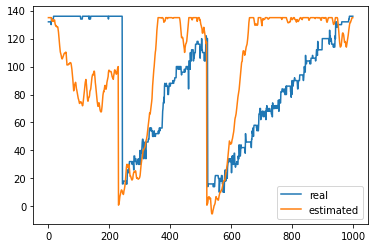

In [14]:
max_height = 135
min_height = 20
clearing_intevall = [230, 520]


def height_vs_deltaSum(c_id, size):
    total = 135
    
    real_height = df_smoothed.loc[df_smoothed["container_id"] == str(c_id)]
    real_height = np.array(real_height["real_height"][:size].tolist()).astype("float32")
    
    est_height = []
    data_point_list = df.loc[df["container_Id"] == str(c_id)]
    data_point_list = data_point_list.drop(columns=["container_Id"])


    for x in range(size):
        if x in clearing_intevall:
            total = 0
        
        data_point = np.array([data_point_list.iloc[x].tolist()[1:]]).astype("float32")
        pred_delta = delta_model.predict(data_point)[0][0] * 46
        total = total + pred_delta
        if total > max_height:
            total = max_height
        est_height.append(total)

    plt.plot(real_height, label="real")
    plt.plot(est_height, label="estimated")
    plt.legend()
    plt.show()

height_vs_deltaSum(1,1000)

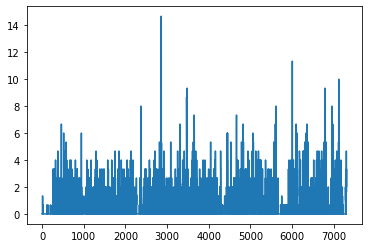

In [15]:
df = df.loc[df["container_Id"] == "1"]
xx = df["height_delta"].values.tolist()
plt.plot(np.array(xx).astype("float32") * 46)

In [16]:
df

,height_delta,temperatur_in_grad,niederschlag_in_mm,ist_industriegebiet,ist_wohngebiet,ist_feiertag,sekunde,minute,stunde,wochentag,...,DEVEUI_70B3D50070001779,DEVEUI_70B3D5007000177C,DEVEUI_70B3D50070001780,DEVEUI_70B3D50070001781,DEVEUI_70B3D50070001782,DEVEUI_70B3D50070001786,DEVEUI_70B3D50070001787,DEVEUI_70B3D50070001788,DEVEUI_70B3D50070001789,container_Id
507731,0.0,0.1969697,0.0,0.0,1.0,0.0,0.0,0.88135594,0.0,0.8333333,...,0,0,0,0,0,0,0,0,0,1
507732,0.0,0.16666667,0.0,0.0,1.0,0.0,1.0,0.86440676,0.04347826,0.8333333,...,0,0,0,0,0,0,0,0,0,1
507733,0.0,0.16666667,0.0,0.0,1.0,0.0,1.0,0.86440676,0.08695652,0.8333333,...,0,0,0,0,0,0,0,0,0,1
507734,0.0,0.1969697,0.0,0.0,1.0,0.0,1.0,0.86440676,0.13043478,0.8333333,...,0,0,0,0,0,0,0,0,0,1
507735,0.0,0.18181819,0.0,0.0,1.0,0.0,1.0,0.86440676,0.17391305,0.8333333,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515032,0.10144926,0.3030303,0.0,0.0,1.0,0.0,1.0,0.42372882,0.6956522,0.8333333,...,0,0,0,0,0,0,0,0,0,1
515033,0.04347826,0.28787878,0.0,0.0,1.0,0.0,1.0,0.42372882,0.73913044,0.8333333,...,0,0,0,0,0,0,0,0,0,1
515034,0.1014493,0.22727273,0.0,0.0,1.0,0.0,1.0,0.42372882,0.7826087,0.8333333,...,0,0,0,0,0,0,0,0,0,1
515035,0.07246378,0.25757575,0.0,0.0,1.0,0.0,0.084745765,0.44067797,0.82608694,0.8333333,...,0,0,0,0,0,0,0,0,0,1


In [17]:
data_in = df.values.tolist()
data_in = np.array(data_in).astype("float32")
data_in = data_in[:, 1:len(data_in[0])-1]
len(data_in[0])

97

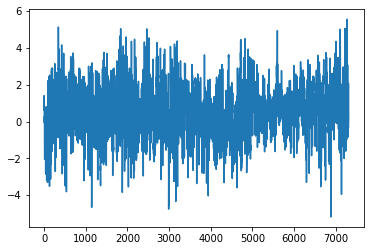

In [18]:
pp = []
for x in range(len(data_in)):
    data_point = np.array([data_in[x]])
    pred_height = delta_model.predict(data_point)[0][0] * 46
    pp.append(pred_height)
pp = np.array(pp).astype("float32")
plt.plot(pp)